In [1]:
!pip install netCDF4
!pip install xarray
!pip install xbatcher
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.5/890.5 kB 13.1 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import IterableDataset
import numpy as np
from tqdm import tqdm
from netCDF4 import Dataset as NetCDFFile
import xarray as xr
import matplotlib.pyplot as plt
# import gc
import xbatcher
# import Geohash
import os
import pickle

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
os.chdir("/content/drive/My Drive")

In [5]:
# just fingerprints (output from David's code)
fingerprint_file = r'projects/EPS 91/SSH_Patterns.nc'

# full ocean dynamics (output from Sonke's code)
ocean_dynamics_file = r'projects/EPS 91/GLORYS_Surrogate_Combined_40320sims.nc'

synthetics_file = r'projects/EPS 91/synthetics.pkl'

In [6]:
# synthetic fingerprints dataset
immutable_fingerprints = xr.open_dataset(fingerprint_file)
fingerprints = immutable_fingerprints.copy(deep=True)

#### Visualize Synthetic Fingerprints

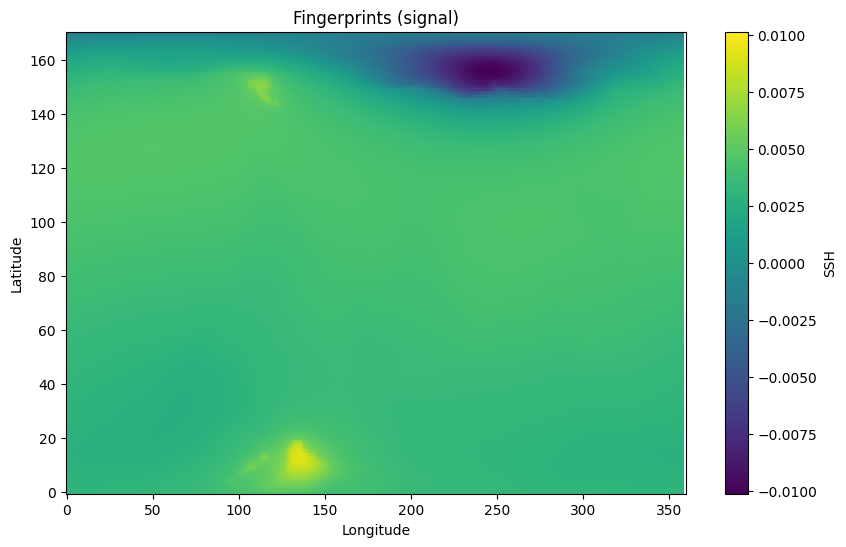

In [7]:
# Select timestep/simualtion number
fingerprint_data_slice = fingerprints['SSH'].isel(time=0, nsim=0)

plt.figure(figsize=(10, 6))
fingerprint_data_slice.plot(cmap='viridis')
plt.title('Fingerprints (signal)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [8]:
# synthetic ocean dynamics dataset
immutable_ocean_dynamics = xr.open_dataset(ocean_dynamics_file)
ocean_dynamics = immutable_ocean_dynamics.copy(deep=True)

#### Visualize Synthetic Ocean Dynamics Field

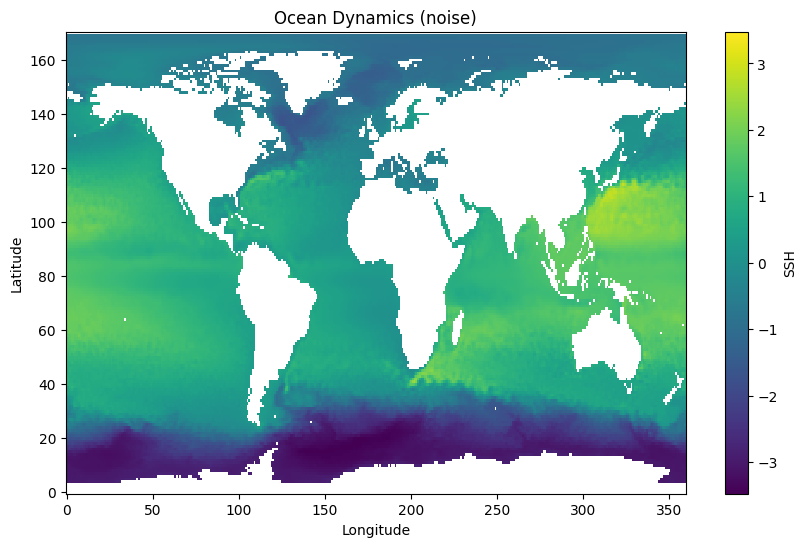

In [9]:
# Select timestep/simualtion number
surrogate_data_slice = ocean_dynamics['SSH'].isel(time=100, nsim=100)

plt.figure(figsize=(10, 6))
surrogate_data_slice.plot(cmap='viridis')
plt.title('Ocean Dynamics (noise)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [10]:
print(ocean_dynamics['time'])
print('-'*80)
print(fingerprints['time'])

<xarray.DataArray 'time' (time: 336)> Size: 1kB
array([1993.    , 1993.0834, 1993.1666, ..., 2020.75  , 2020.8334, 2020.9166],
      dtype=float32)
Coordinates:
  * time     (time) float32 1kB 1.993e+03 1.993e+03 ... 2.021e+03 2.021e+03
--------------------------------------------------------------------------------
<xarray.DataArray 'time' (time: 336)> Size: 1kB
array([9.96921e+36, 9.96921e+36, 9.96921e+36, ..., 9.96921e+36, 9.96921e+36,
       9.96921e+36], dtype=float32)
Coordinates:
  * time     (time) float32 1kB 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36


In [11]:
with open(synthetics_file, 'rb') as file:
    synthetics = pickle.load(file)

In [12]:
# Define the dimensions for the dataset
synthetics_ds = xr.Dataset(
    {
        'SSH': (['time', 'lat', 'lon', 'nsim'], synthetics['SSH'].values)
    }
)

# Check the dataset structure
print(synthetics_ds)

<xarray.Dataset> Size: 10GB
Dimensions:  (time: 336, lat: 171, lon: 360, nsim: 120)
Dimensions without coordinates: time, lat, lon, nsim
Data variables:
    SSH      (time, lat, lon, nsim) float32 10GB nan nan nan nan ... nan nan nan


#### Visualize Full Synthetic Field

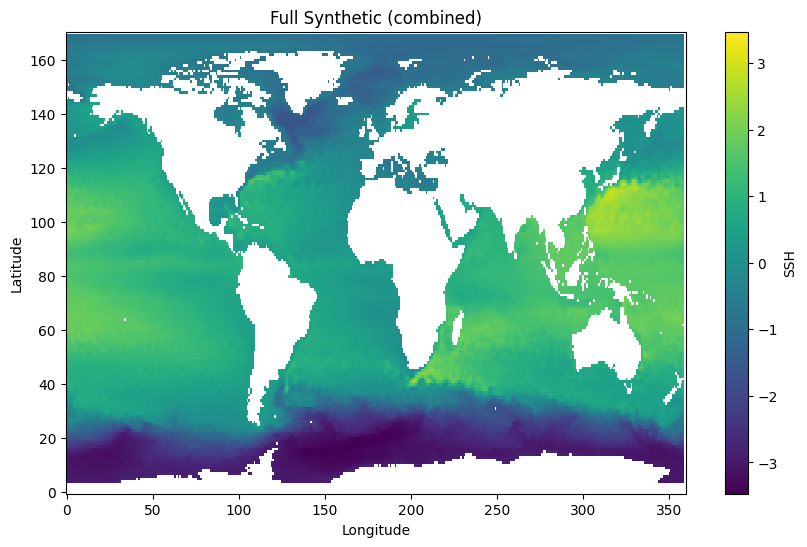

In [13]:
combined_ssh_slice = synthetics_ds['SSH'].isel(time=100, nsim=100)
plt.figure(figsize=(10, 6))
combined_ssh_slice.plot(cmap='viridis')
plt.title('Full Synthetic (combined)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

#### Generate batches of data for training. Input_gen full ocean dynamics combined with fingerprints and target_gen contains only fingerprint (our model's prediction targets)

#### Train/Validation splits and Batch Generators

In [14]:
def prepare_data(data, mode, offset=5, lat_start=120, lon_start=50):

  if mode == 'patch':

    data_patch = data.isel(lat=slice(lat_start, lat_start + offset), lon=slice(lon_start, lon_start + offset))

    data_collapsed = data_patch.stack(sim=('time', 'nsim'))

    split_idx = int(0.8 * data_collapsed.sizes['sim'])

    data_train = data_collapsed.isel(sim=slice(0, split_idx))

    data_val = data_collapsed.isel(sim=slice(split_idx, None))

    train_data_gen = xbatcher.BatchGenerator(data_train, {'sim': split_idx, 'lat': offset, 'lon': offset})

    val_data_gen = xbatcher.BatchGenerator(data_val, {'sim': data_val.sizes['sim'], 'lat': offset, 'lon': offset})

  elif mode == 'global':

    offset= 100

    data_patch = data.isel(lat=slice(0, 171), lon=slice(0, 360))

    data_collapsed = data_patch.stack(sim=('time', 'nsim'))

    data_collapsed = data_collapsed.isel(sim=slice(0, offset))

    split_idx = int(0.8 * data_collapsed.sizes['sim'])

    data_train = data_collapsed.isel(sim=slice(0, split_idx))

    data_val = data_collapsed.isel(sim=slice(split_idx, None))

    train_data_gen = xbatcher.BatchGenerator(data_train, {'sim': split_idx, 'lat': 171, 'lon': 360})

    val_data_gen = xbatcher.BatchGenerator(data_val, {'sim': data_val.sizes['sim'], 'lat': 171, 'lon': 360})

  else:
    raise ValueError("Invalid mode. Choose 'patch' or 'global'.")

  return train_data_gen, val_data_gen


In [15]:
# combined_train, combined_val = prepare_data(synthetics_ds, 'patch')
# noise_train, noise_val = prepare_data(ocean_dynamics, 'global')
signal_train, signal_val = prepare_data(fingerprints, 'global')

In [16]:
del immutable_fingerprints, fingerprints, immutable_ocean_dynamics, ocean_dynamics, synthetics, synthetics_ds

In [17]:
# Function to visualize input, prediction, and target for multiple samples
def visualize_examples(inputs, predictions, targets, offset, num_examples=5):

    for i in range(num_examples):
        input_sample = inputs[:, :, i].squeeze().numpy()  # (5, 5)
        prediction_sample = predictions[:, :, i].detach().numpy().reshape(offset, offset)  # Reshape to (offset, offset)
        target_sample = targets[:, :, i].detach().numpy().reshape(offset, offset)  # Reshape to (offset, offset)

        # Plot input, prediction, and target side by side
        fig, axes = plt.subplots(1, 3, figsize=(offset*5, offset))

        # Input visualization
        im0 = axes[0].imshow(input_sample, cmap='viridis', interpolation='none')
        axes[0].set_title(f"Combined {i + 1}")
        axes[0].axis('off')
        fig.colorbar(im0, ax=axes[0])  # Add colorbar for prediction


        # Prediction visualization
        im1 = axes[1].imshow(prediction_sample, cmap='viridis', interpolation='none')
        axes[1].set_title(f"Ocean Dynamics (noise) {i + 1}")
        axes[1].axis('off')
        fig.colorbar(im1, ax=axes[1])  # Add colorbar for prediction


        # Target visualization
        im2 = axes[2].imshow(target_sample, cmap='viridis', interpolation='none')
        axes[2].set_title(f"Fingerprints (signal) {i + 1}")
        axes[2].axis('off')
        fig.colorbar(im2, ax=axes[2])  # Add colorbar for prediction


        plt.show()

In [18]:
def z_score_normalize(a):

  func = lambda x: (x - np.mean(x)) / np.std(x)
  return xr.apply_ufunc(func, a)

def max_normalize(a):

  def func(x):
    # Get the maximum absolute value
    max_val = np.max(np.abs(x))
    if max_val != 0:
      # Normalize by max absolute value
      return x / max_val
    else:
      # Handle case where max is zero
      return np.zeros_like(x)
  return xr.apply_ufunc(func, a)

def std_normalize(a):

  def func(x):
    # Get standard deviation
    std = np.std(x)  
    if std != 0:
      return x / std  
    # Normalize by standard deviation
    else:
      # Handle case where max is zero
      return np.zeros_like(x)
        

  return xr.apply_ufunc(func, a)

def patch_normalize(a):

  def func(x):
    max_val = np.abs(np.max(np.abs(x), axis=(1, 2), keepdims=True))
    # Normalize while avoiding division by zero
    return np.divide(x, max_val, where=max_val != 0)

  # Apply function to each patch
  return xr.apply_ufunc(func, a, input_core_dims=[['sim', 'lat', 'lon']],
                          output_core_dims=[['sim', 'lat', 'lon']],
                          vectorize=True,
                          dask='allowed')

In [19]:
def print_stats(data, data_per, name):
  data_min = np.min(data)
  data_max = np.max(data)
  data_med = np.median(data)

  d = {
      'name': name,
      'min': round(data_min, 4),
      '10th per': round(data_per[1], 4),
      'mean': round(data_per[2], 4),
      'median': round(data_med, 4),
      '90th per': round(data_per[3], 4),
      'max': round(data_max, 4),
      'std': round(np.std(data), 4)
  }

  return d

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
import pandas as pd
from IPython.display import display

# Function to visualize distributions
def visualize_distributions(inputs, name):
    pers = [5, 10, 50, 90, 95]
    [noise_train_flat, z_score_flat, max_norm_flat, std_norm_flat] = inputs

    fig, axes = plt.subplots(1, 4, figsize=(18, 6))

    noise_train_per = np.percentile(noise_train_flat, pers)
    sns.histplot(noise_train_flat, ax=axes[0], bins=10000, kde=True)
    [axes[0].axvline(x=x, color='red', linestyle='--') for x in noise_train_per[1:-1]]
    lower, upper = noise_train_per[0], noise_train_per[-1]
    range_ = upper - lower
    axes[0].set_xlim(lower - range_ * 0.1, upper + range_ * 0.1)
    axes[0].set_title(name + ' Distribution - Raw')
    axes[0].set_xlabel('Value')
    axes[0].set_ylabel('Density')
    noise_stats = print_stats(noise_train_flat, noise_train_per, 'raw')

    z_score_per = np.percentile(z_score_flat, pers)
    sns.histplot(z_score_flat, ax=axes[1], bins=10000, kde=True)
    [axes[1].axvline(x=x, color='red', linestyle='--') for x in z_score_per[1:-1]]
    lower, upper = z_score_per[0], z_score_per[-1]
    range_ = upper - lower
    axes[1].set_xlim(lower - range_ * 0.1, upper + range_ * 0.1)
    axes[1].set_title(name + ' Distribution - Z-Score Norm')
    axes[1].set_xlabel('Value')
    axes[1].set_ylabel('Density')
    z_score_stats = print_stats(z_score_flat, z_score_per, 'z score norm')

    max_norm_per = np.percentile(max_norm_flat, pers)
    sns.histplot(max_norm_flat, ax=axes[2], bins=10000, kde=True)
    [axes[2].axvline(x=x, color='red', linestyle='--') for x in max_norm_per[1:-1]]
    lower, upper = max_norm_per[0], max_norm_per[-1]
    range_ = upper - lower
    axes[2].set_xlim(lower - range_ * 0.1, upper + range_ * 0.1)
    axes[2].set_title(name + ' Distribution - Global Max Norm')
    axes[2].set_xlabel('Value')
    axes[2].set_ylabel('Density')
    max_norm_stats = print_stats(max_norm_flat, max_norm_per, 'global max norm')

    std_norm_per = np.percentile(std_norm_flat, pers)
    sns.histplot(std_norm_flat, ax=axes[3], bins=10000, kde=True)
    [axes[3].axvline(x=x, color='red', linestyle='--') for x in std_norm_per[1:-1]]
    lower, upper = std_norm_per[0], std_norm_per[-1]
    range_ = upper - lower
    axes[3].set_xlim(lower - range_ * 0.1, upper + range_ * 0.1)
    axes[3].set_title(name + ' Distribution - Std Norm')
    axes[3].set_xlabel('Value')
    axes[3].set_ylabel('Density')
    std_norm_stats = print_stats(std_norm_flat, std_norm_per, 'std norm')

    stats_df = pd.DataFrame([noise_stats, z_score_stats, max_norm_stats, std_norm_stats])
    display(stats_df)

    def format_ticks(value, tick_number):
        return f"{value:.4f}"

    # Apply formatting to all x-axes
    for i in range(4):
        axes[i].xaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))
        plt.setp(axes[i].get_xticklabels(), rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

In [21]:
import numpy as np

def nan_filter(input, threshold=0.2, patch_dim=5):
# Input is size 30,000 x 171 x 360. Convert to smaller patch size
  sim_dim = input.sizes['sim']
  lat_dim = input.sizes['lat']
  lon_dim = input.sizes['lon']

  input_gen = xbatcher.BatchGenerator(input, {'sim': sim_dim, 'lat': patch_dim, 'lon': patch_dim})
  tmp = []
  for batch in input_gen:

    batch = np.transpose(batch['SSH'].values, (2, 0, 1)) # size 30,000 x patch_dim, patch_dim
    input_filtered = np.nan_to_num(batch, nan=0)
    zero_count = np.count_nonzero(input_filtered == 0, axis=(1, 2))
    total_pixels = input_filtered.shape[1] * input_filtered.shape[2]
    zero_ratio = zero_count / total_pixels
    mask = zero_ratio <= threshold
    filtered_patches = input_filtered[mask]
    tmp.append(filtered_patches)

  filtered_array = np.concatenate(tmp, axis=0)
  filtered_array = xr.DataArray(filtered_array, dims=('lat', 'lon', 'sim'), coords={'lat': lat_dim, 'lon': lon_dim, 'sim': sim_dim})
  filtered_array = filtered_array.astype(np.float16)

  return filtered_array


,name,min,10th per,mean,median,90th per,max,std
0,raw,-0.8159,0.0009,0.0055,0.0055,0.0087,1.644500,0.0353
1,z score norm,-23.2314,-0.1043,0.0243,0.0243,0.1161,46.429100,1.0000
2,global max norm,-0.4961,0.0006,0.0033,0.0033,0.0053,1.000000,0.0215
3,std norm,-23.1003,0.0267,0.1553,0.1553,0.2471,46.560101,1.0000


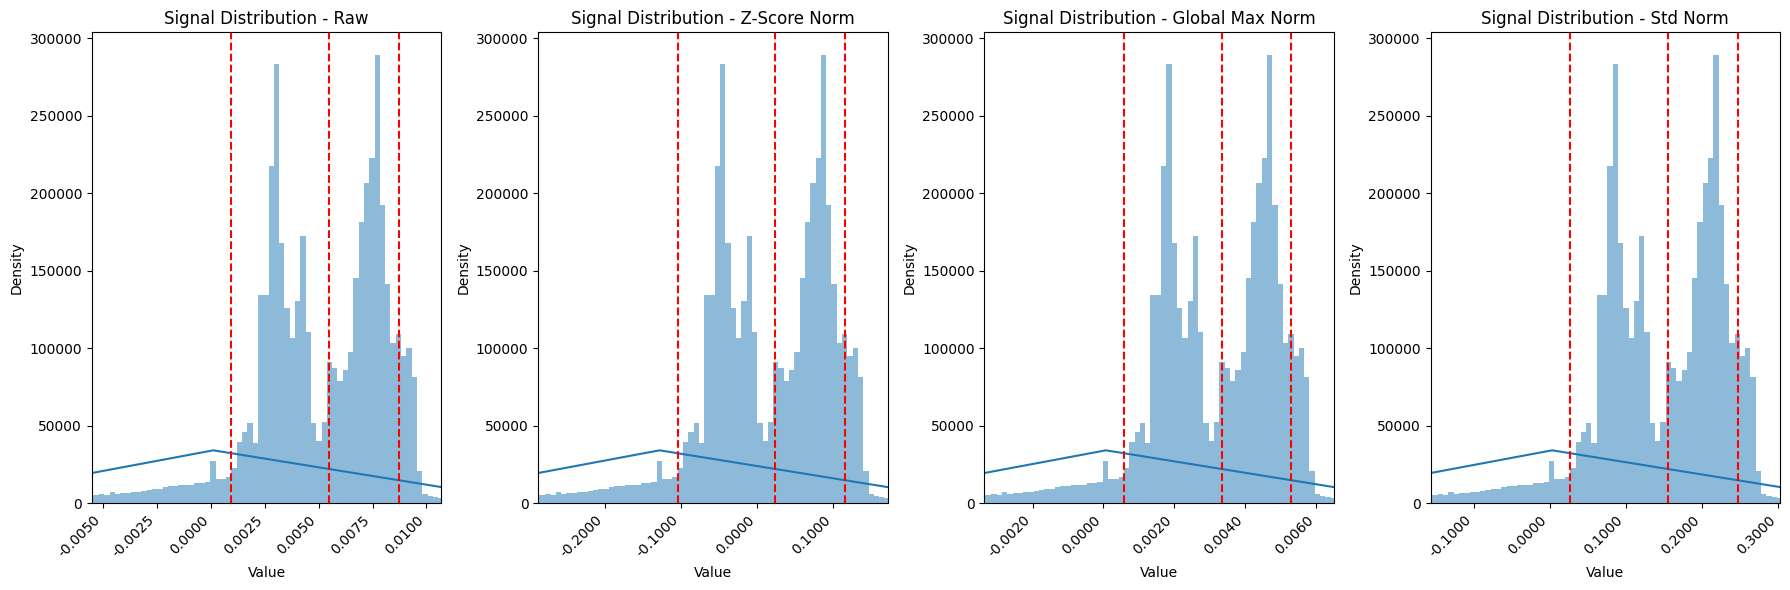

In [22]:
for signal_batch in signal_train:

  filtered_signal_batch = nan_filter(signal_batch)

  if filtered_signal_batch.sizes['sim'] == 0:
    continue

  filtered_signal_batch = filtered_signal_batch.astype(np.float32)
  z_score_batch = z_score_normalize(filtered_signal_batch)
  max_norm_batch = max_normalize(filtered_signal_batch)
  std_norm_batch = std_normalize(filtered_signal_batch)

  signal_batch_flat = filtered_signal_batch.values.flatten()
  z_score_batch_flat = z_score_batch.values.flatten()
  max_norm_batch_flat = max_norm_batch.values.flatten()
  std_norm_batch_flat = std_norm_batch.values.flatten()

  del signal_batch, z_score_batch, max_norm_batch, std_norm_batch
  norm_inputs = [signal_batch_flat, z_score_batch_flat, max_norm_batch_flat, std_norm_batch_flat]
  visualize_distributions(norm_inputs, 'Signal')

In [23]:
del signal_batch_flat, z_score_batch_flat, max_norm_batch_flat, std_norm_batch_flat, norm_inputs

# Based on the experiments above, we have decided to use global_max_norm as our standardization technique. This method places our noise/signal on similar scales and helps reduce the impact of outliers on predictions.